In [1]:
# model implementation
from ml.models.nn import MLP
from ml.functions.loss import CrossEntropyLoss
from ml.algorithms.optimization import BackpropSGD
from ml.functions.activation import Sigmoid, Identity, Relu

# model selection
from ml.model_selection import GridSearchCV

from ml.functions.metrics.classification import F1Score, BinaryAccuracy, MulticlassClassificationError
from ml.functions.metrics.regression import RMSE, MAE, MRE

from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing

np.random.seed(25)

## Q1 - Neural Net for classification

### Load dataset
I'm using my implmenentation of k-fold with cross validation to find best hyperparameters.

The code which splits the dataset into **train, validation and test** is left for reference.

In [2]:
X, y = load_csv('./datasets/vowel.csv')

# one-hot encoding
y = y.astype(int).squeeze()

onehot_dim = (y.shape[0], y.max()+1)
rows = np.arange(y.shape[0])

y_onehot = np.zeros(onehot_dim)
y_onehot[rows, y] = 1

#### Split into train (60%), validation (20%) and test (20%) - unused

In [3]:
# X_train, y_train, X_test, y_test = split_train_test(X, Y, 0.6, shuffle=True)
# X_train, y_train, X_val, y_val = split_train_test(X_train, y_train, 0.75, shuffle=False)

#### Split into train (70%) and test (30%)

In [4]:
X_train, y_train, X_test, y_test = split_train_test(X, y_onehot, 0.7, shuffle=True)

### Scale data

In [5]:
# scale dataset
x_scaler = MinMaxScaler().fit(X_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

### Find best hyperparameters (num neurons and activation function) using grid search

In [61]:
solver = BackpropSGD(epochs=3000,
                    learning_rate=0.15,
                    regularization=0,
                    momentum=0.9,
                    batch_size=32,
                    metrics=MulticlassClassificationError())
layers = (
    (64, Sigmoid()),
    (11, Sigmoid()),
)

mlp = MLP(layers=layers, solver=solver, loss=CrossEntropyLoss)

train_err, test_err = mlp.fit(
    X_train_scaled, y_train,
    X_test_scaled,  y_test)

Text(0.5, 0, 'Epoch')

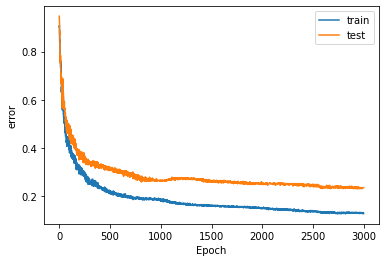

In [62]:
plt.plot(train_err, label="train")
plt.plot(test_err, label="test")
plt.legend()
plt.ylabel("error")
plt.xlabel("Epoch")

In [8]:

pred = mlp.predict(X_test)

print(pred.shape, np.argmax(pred, axis=1).shape)
print(y_test.shape, np.argmax(y_test, axis=1).shape)

print("pred=", np.argmax(pred, axis=1))
print("test=", np.argmax(y_test, axis=1))

(297, 11) (297,)
(297, 11) (297,)
pred= [8 3 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 3 8 8 8 8 8 8 3 8 3 8 8 8 8 8 8 8 3 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 8
 3 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 2 8 8 8 8
 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 8 3 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 3 8 2 8 8 8 8 8 8 8 8 8 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8
 2]
test= [ 8  0  3  2  5 10 10  8  3  0  4  8  9  5  8  1  2 10  6  8  4  5  6  7
  0  2  6  7  7  4  1  4  9  5  3  1  1  4  6  6  2  4  1  1  8  0  5  1
  1  6  6  2  3  9  0  8  4  9  6  2  0  8  6  0  9  7  7  2  7  5  4  6
 10  3  4  8  8  4  8  7  2  2  1  1  3  6 10  4  0  7  1  4  4  9  3  8
  2  4  6  0 10  3  6  2 10  4  7  4  0 10  2  8 10  3  8 

In [9]:
mlp.is_multiclass

True

In [10]:
mlp.is_classifier

True

In [11]:
# y_hat = mlp.predict_proba(X_test_scaled)

# acc = BinaryAccuracy()
# acc.measure(y_test, y_hat)

In [12]:
# grid = GridSearchCV()

# # fixed hyperparams
# reg = 0.001
# momentum=0.8

# for lr in [0.1]:
#     for num_neurons in [16, 32]:
#         for function in [Relu, Sigmoid]:

#             solver = BackpropSGD(epochs=1000,
#                         learning_rate=lr,     # <-- hyperparam under test
#                         regularization=reg,
#                         momentum=momentum,
#                         batch_size=32,
#                         metrics=RMSE())

#             layers = (
#                 (num_neurons, function()),     # <-- hyperparams under test
#                 (1, Sigmoid()),
#             )

#             grid.add(MLP, {
#                 "layers":layers,
#                 "input_width": X_train.shape[1],
#                 "solver": solver,
#                 "is_classifier": True})

# best = grid.search(X_train_scaled, y_train_scaled, num_folds=10, shuffle=False)

### Hyperparameters of the best MLP

In [13]:
# print("Best hyperparameters for MLP:", best[1])

## Drafts